In [6]:
import numpy as np
from scipy.stats import pearsonr

import NPI
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def flat_without_diagonal(matrix):

    "Flatten the matrix without including the diagonal"

    n = matrix.shape[0]
    flattened = []
    for i in range(n):
        for j in list(range(i)) + list(range(i + 1, n)):
            flattened.append(matrix[i][j])

    return np.array(flattened)

In [8]:
batch_size              = 50
train_set_proportion    = 0.8
ROI_num                 = 360
using_steps             = 3

In [26]:
# Parcellation function
def simple_parcellation(data, n_regions=360):
    n_timepoints, n_grayords = data.shape
    grayords_per_region = n_grayords // n_regions
    parcellated = np.zeros((n_timepoints, n_regions))

    for region in range(n_regions):
        start = region * grayords_per_region
        end = n_grayords if region == n_regions-1 else (region+1) * grayords_per_region
        parcellated[:, region] = np.mean(data[:, start:end], axis=1)

    return parcellated

files = [
    '/content/102008_REST1_LR.txt',
    '/content/102008_REST1_RL.txt',
    '/content/102008_REST2_LR.txt',
    '/content/102008_REST2_RL.txt'
]

signals = []
inputs = []
targets = []

# Load each session
for i, filepath in enumerate(files):
    try:
        print(f"\nSession {i+1}/4: {filepath.split('/')[-1]}")

        # Load ALL grayordinates
        raw = np.loadtxt(filepath)[30:, :]  # Drop 30 TRs, keep ALL columns
        print(f"  Loaded: {raw.shape}")

        # Parcellate: 91,282 → 360 regions
        parcellated = simple_parcellation(raw, n_regions=ROI_num)
        print(f"  Parcellated: {parcellated.shape}")

        # Normalize
        normalized = stats.zscore(parcellated, axis=0)

        # Create pairs
        inp, targ = NPI.multi2one(normalized, steps=using_steps)

        # Store
        signals.append(normalized)
        inputs.append(inp)
        targets.append(targ)

        print(f"Completed")

    except FileNotFoundError:
        print(f"File not found, skipping...")
        continue

print(f"\nLoaded {len(signals)}/4 sessions")
print(f"Ready for training with {len(signals)} sessions!")


Session 1/4: 102008_REST1_LR.txt
  Loaded: (1170, 379)
  Parcellated: (1170, 360)
Completed

Session 2/4: 102008_REST1_RL.txt
  Loaded: (1170, 379)
  Parcellated: (1170, 360)
Completed

Session 3/4: 102008_REST2_LR.txt
  Loaded: (1170, 379)
  Parcellated: (1170, 360)
Completed

Session 4/4: 102008_REST2_RL.txt
  Loaded: (1170, 379)
  Parcellated: (1170, 360)
Completed

Loaded 4/4 sessions
Ready for training with 4 sessions!


In [10]:
# Combine sessions into single arrays
input_X = np.vstack(inputs)
target_Y = np.vstack(targets)

print(f"Combined: input_X {input_X.shape}, target_Y {target_Y.shape}")

Combined: input_X (4668, 1080), target_Y (4668, 360)


In [12]:
neworderlr = np.loadtxt('/content/neworderlr.txt')
neworder = np.array([np.where(neworderlr == i)[0][0] for i in range(len(neworderlr))])
oldorder = np.array([np.where(neworder == i)[0][0] for i in range(len(neworder))])

In [27]:
ANN = NPI.ANN_MLP(
    input_dim=using_steps * ROI_num,
    hidden_dim=4 * ROI_num,
    latent_dim=int(2 * ROI_num),
    output_dim=ROI_num
)

print("Training...")
ANN, training_loss, testing_loss = NPI.train_NN(
    ANN,
    input_X,
    target_Y,
    batch_size=128,
    train_set_proportion=0.80,
    num_epochs=200,
    lr=3e-4,
    l2=1e-6
)

print(f"Final loss: {testing_loss[-1]:.4f}")

Training...
Final loss: 0.1840


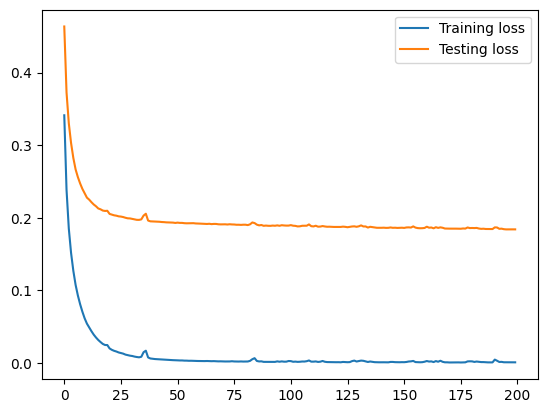

In [28]:
plt.plot(training_loss, label = 'Training loss')
plt.plot(testing_loss, label = 'Testing loss')
plt.legend(loc = 'upper right')
plt.show()

In [29]:
empirical_FC = NPI.corrcoef(np.vstack(signals))
model_FC = NPI.model_FC(ANN, node_num = ROI_num, steps = using_steps)

In [30]:
NPI_EC = NPI.model_EC(ANN, input_X, target_Y, pert_strength=1.0)
np.fill_diagonal(NPI_EC, 0)

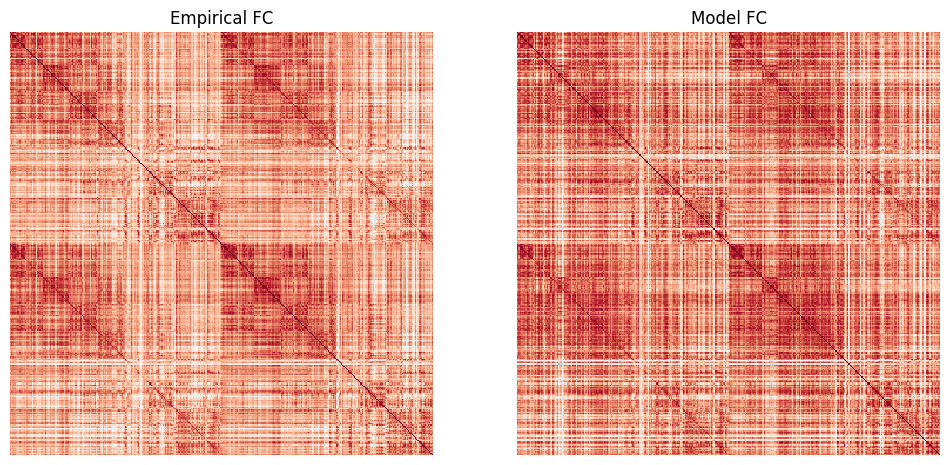

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(empirical_FC[neworder].T[neworder].T, ax = ax1, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
sns.heatmap(model_FC[neworder].T[neworder].T, ax = ax2, vmin = -1.0, vmax = 1.0, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
ax1.set_title('Empirical FC'); ax2.set_title('Model FC')
plt.show()

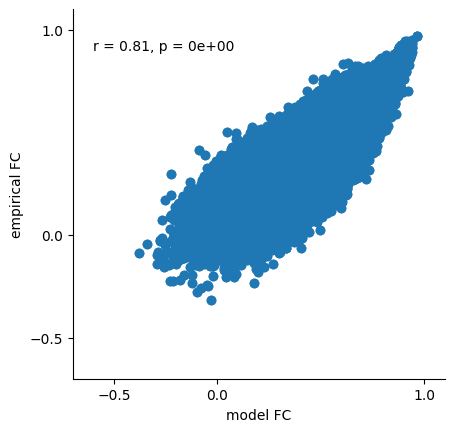

In [32]:
r_value, p_value = pearsonr(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.figure(figsize = (4.8, 4.8))
plt.scatter(flat_without_diagonal(model_FC), flat_without_diagonal(empirical_FC))

plt.xlim(-0.7, 1.1); plt.xticks([-0.5, 0.0, 1.0]); plt.xlabel('model FC')
plt.ylim(-0.7, 1.1); plt.yticks([-0.5, 0.0, 1.0]); plt.ylabel('empirical FC')
plt.text(-0.6, 0.9, 'r = {:.2f}, p = {:.0e}'.format(r_value, p_value))

ax = plt.gca()
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)

plt.show()


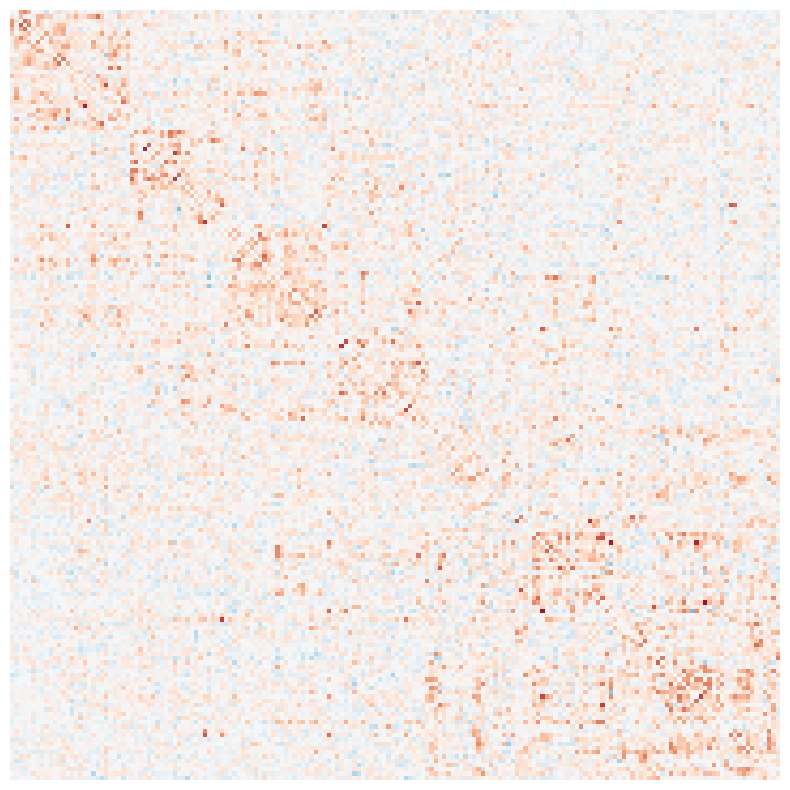

In [33]:
fig = plt.figure(figsize = (10, 10))
sns.heatmap(NPI_EC[neworder].T[neworder].T[:180, :180], vmin = -0.1, vmax = 0.1, cmap = 'RdBu_r', cbar = False, square = True, xticklabels = False, yticklabels = False)
plt.show()